In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import cv2

# Set parameters
IMG_HEIGHT = 181
IMG_WIDTH = 181
BATCH_SIZE = 32
NUM_CLASSES = 7  # 7 classes: ["Bishop", "Rook", "Queen", etc., and empty]
EPOCHS = 30
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device: {DEVICE}')


Using device: cuda


In [2]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_HEIGHT, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalization for grayscale
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalization for grayscale
])


In [3]:
# Load the dataset using ImageFolder
train_dataset = datasets.ImageFolder('piece train', transform=train_transforms)
val_dataset = datasets.ImageFolder('piece valid', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print the class names to verify
print(f"Classes: {train_dataset.classes}")


Classes: ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook', 'empty']


In [ ]:
# Load pretrained MobileNetV2
base_model = models.mobilenet_v2(pretrained=True)
base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, NUM_CLASSES)
base_model = base_model.to(DEVICE)

# Print model architecture
# print(base_model)


In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=LEARNING_RATE)


In [6]:
# Training function with early stopping
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=EPOCHS, patience=10):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_val_loss = float('inf')
    early_stop_counter = 0  # To count epochs with no improvement
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_preds = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss, val_correct_preds = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels)

        val_loss_epoch = val_running_loss / len(val_loader.dataset)
        val_acc_epoch = val_correct_preds.double() / len(val_loader.dataset)
        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch.item())

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

        # Early stopping logic
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            early_stop_counter += 1  # Increment if no improvement

        # Stop training if patience is exceeded
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    return train_loss, val_loss, train_acc, val_acc


In [7]:
# Train the model
train_loss, val_loss, train_acc, val_acc = train_model(base_model, criterion, optimizer, train_loader, val_loader)


Epoch 1/30, Train Loss: 0.7304, Train Acc: 0.7926, Val Loss: 0.2752, Val Acc: 0.8978
Epoch 2/30, Train Loss: 0.0886, Train Acc: 0.9822, Val Loss: 0.1997, Val Acc: 0.9303
Epoch 3/30, Train Loss: 0.0385, Train Acc: 0.9921, Val Loss: 0.1223, Val Acc: 0.9712
Epoch 4/30, Train Loss: 0.0309, Train Acc: 0.9946, Val Loss: 0.1187, Val Acc: 0.9760
Epoch 5/30, Train Loss: 0.0132, Train Acc: 0.9983, Val Loss: 0.0695, Val Acc: 0.9808
Epoch 6/30, Train Loss: 0.0126, Train Acc: 0.9988, Val Loss: 0.0689, Val Acc: 0.9796
Epoch 7/30, Train Loss: 0.0134, Train Acc: 0.9971, Val Loss: 0.0776, Val Acc: 0.9772
Epoch 8/30, Train Loss: 0.0149, Train Acc: 0.9946, Val Loss: 0.0965, Val Acc: 0.9700
Epoch 9/30, Train Loss: 0.0121, Train Acc: 0.9971, Val Loss: 0.0848, Val Acc: 0.9712
Epoch 10/30, Train Loss: 0.0056, Train Acc: 0.9988, Val Loss: 0.1077, Val Acc: 0.9663
Epoch 11/30, Train Loss: 0.0087, Train Acc: 0.9975, Val Loss: 0.0622, Val Acc: 0.9832
Epoch 12/30, Train Loss: 0.0028, Train Acc: 1.0000, Val Loss: 0

In [8]:
# Save the entire model
torch.save(base_model, 'chess_piece_classifier.pth')


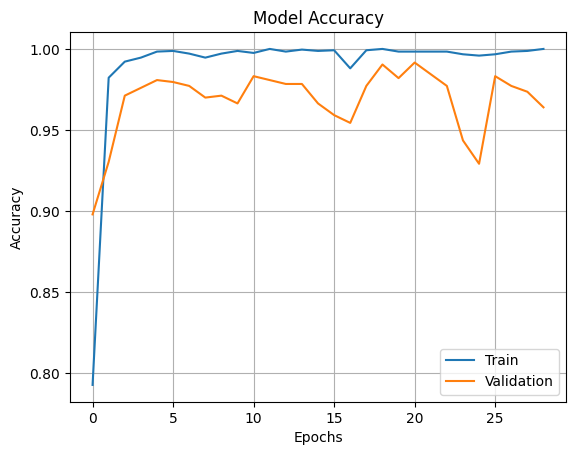

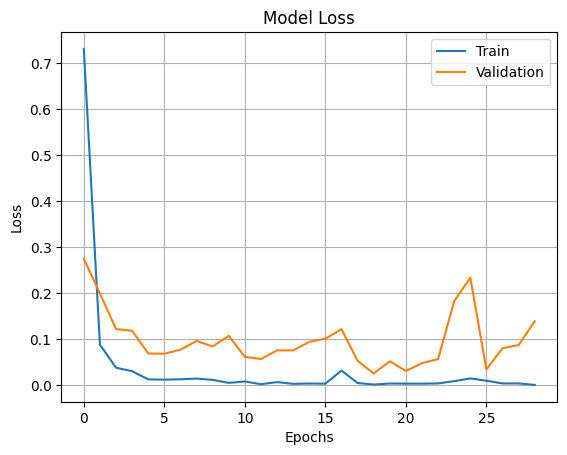

In [9]:
# Plot accuracy and loss
def plot_metrics(train_metric, val_metric, metric_name='Accuracy'):
    plt.plot(train_metric, label='Train')
    plt.plot(val_metric, label='Validation')
    plt.title(f'Model {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy and loss
plot_metrics(train_acc, val_acc, 'Accuracy')
plot_metrics(train_loss, val_loss, 'Loss')


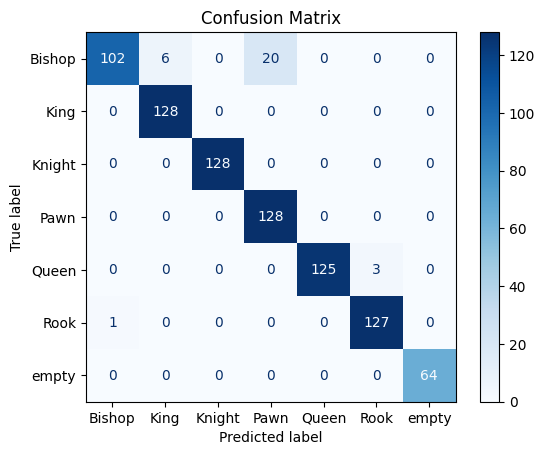

In [10]:
# Evaluate the model and show confusion matrix
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    return all_preds, all_labels

# Get predictions and labels
y_pred, y_true = evaluate_model(base_model, val_loader)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [11]:
def predict_image(model, image_path, transform, class_names):
    model.eval()
    img = Image.open(image_path).convert("L")  # Convert to grayscale ("L" mode in PIL for 8-bit pixels, black and white)
    img = img.convert("RGB")  # Convert back to 3 channels to match the model input
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)
    
    return class_names[pred.item()]


In [12]:
for i in range(64):
    img_path = f'actual pieces/pic{i}.png'  # Define the image path
    predicted_class = predict_image(base_model, img_path, val_transforms,train_dataset.classes )  # Predict the piece class
    print(f"Image {i}: Predicted piece class = {predicted_class}")  # Print the prediction


Image 0: Predicted piece class = Rook
Image 1: Predicted piece class = Queen
Image 2: Predicted piece class = Bishop
Image 3: Predicted piece class = empty
Image 4: Predicted piece class = King
Image 5: Predicted piece class = Bishop
Image 6: Predicted piece class = empty
Image 7: Predicted piece class = Rook
Image 8: Predicted piece class = Pawn
Image 9: Predicted piece class = Pawn
Image 10: Predicted piece class = empty
Image 11: Predicted piece class = Pawn
Image 12: Predicted piece class = empty
Image 13: Predicted piece class = Pawn
Image 14: Predicted piece class = Pawn
Image 15: Predicted piece class = Pawn
Image 16: Predicted piece class = empty
Image 17: Predicted piece class = empty
Image 18: Predicted piece class = Knight
Image 19: Predicted piece class = empty
Image 20: Predicted piece class = Pawn
Image 21: Predicted piece class = Knight
Image 22: Predicted piece class = empty
Image 23: Predicted piece class = empty
Image 24: Predicted piece class = empty
Image 25: Predic

In [13]:
def display_images_with_predictions(images, predictions):
    # Create a figure to plot the images
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))  # Create an 8x8 grid

    # Loop through images and predictions
    for i in range(len(images)):
        # Load each image
        img = cv2.imread(images[i])  # Read the image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display

        # Get the current axis in the grid
        ax = axes[i // 8, i % 8]

        # Display the image
        ax.imshow(img)
        ax.set_title(predictions[i])  # Set prediction as title

        # Turn off the axis
        ax.axis('off')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


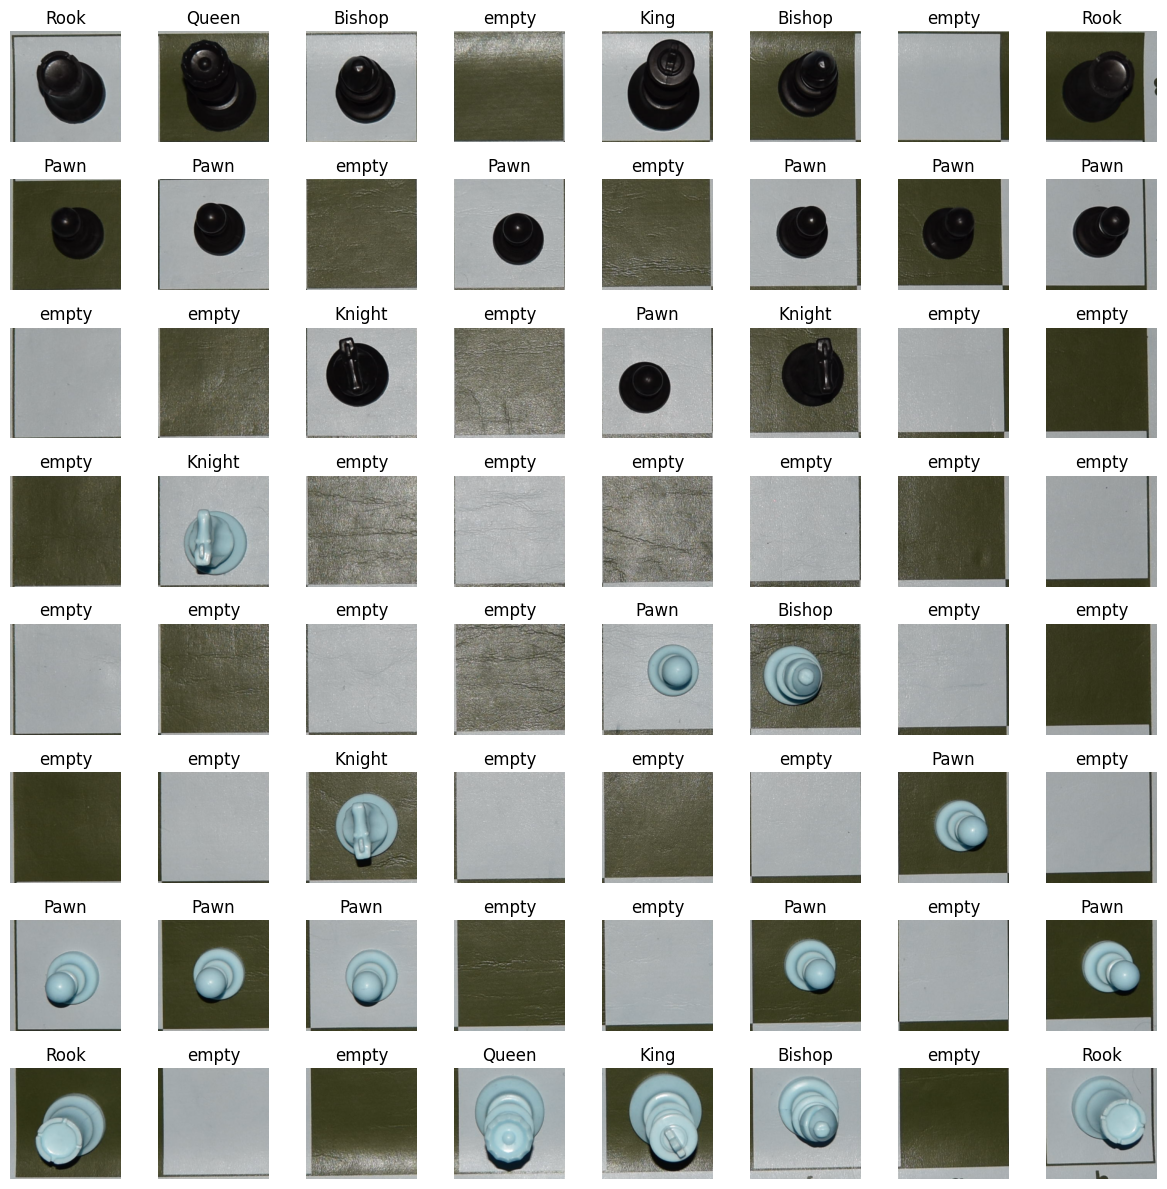

In [14]:
# Prepare the image paths
images_array = [f'actual pieces/pic{i}.png' for i in range(64)]

# Call the function to display images and predictions
class_names = train_dataset.classes
predictions = [predict_image(base_model, img, val_transforms, class_names) for img in images_array]
display_images_with_predictions(images_array, predictions)
